<a name="TOC"></a>
# Dynamics Tutorial 1

In this tutorial we will learn:

* [Topic 1](#model-setup) how to setup a model problem function
* [Topic 2](#pes-scan) how to perform a PES scan for a model problem
* [Topic 3](#initial-conditions) how to initialize the dynamical variables for NA-MD
* [Topic 4](#dynamics) how to setup and run dynamical calculations


In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py.models import Tully
from libra_py.models import Holstein
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import tsh_algo1
from libra_py import dynamics
from libra_py import data_conv

import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

<a name="model-setup"></a> [Back to TOC](#TOC)
## 1. Setting up the model Hamiltonian

To run any types of calculations, we need to define how energies, forces, derivative couplings, etc. should be computed.
This is done in a Python function, which is expected to follow to rules:

1. the input parameters of the function are always: 

   * **q ( MATRIX(ndof, 1) )** - coordinates of the system
   
   * **params (Python dictionary)** - model parameters
   
   * **full_id (intList)** - the identifier of the child - for the (parent) Hamiltonian object to know which of its 
     children to refer to for this particular calculation. This is needed for instance to enable multiple-trajectories 
     simulations at once.
      
      
2. the output object has to have special names of the member elements

   * **ham_dia ( CMATRIX(ndia, ndia) )** - Hamiltonian in the diabatic representation 
   * **ham_adi ( CMATRIX(nadi, nadi) )** - Hamiltonian in the adiabatic representation 
   * **ovlp_dia ( CMATRIX(ndia, ndia) )** - the overlap of the diabatic states
   * **d1ham_dia ( vector of CMATRIX(ndia, ndia) )** - the derivatives of the H_dia w.r.t. all nuclear coordinates
   * **d1ham_adi ( vector of CMATRIX(nadi, nadi) )** - the derivatives of the H_adi w.r.t. all nuclear coordinates
   * **dc1_dia ( vector of CMATRIX(ndia, ndia) )** - the derivatives couplings in the diabatic representation, w.r.t. all the nuclear coordinates   
   * **dc1_adi ( vector of CMATRIX(ndia, ndia) )** - the derivatives couplings in the adiabatic representation, w.r.t. all the nuclear coordinates   

   The object returned by the function can define any of these variables. Depending on the type of calculations (dynamical workflow) the model Hamiltonian (Python) function will be called, some of these variables will be expected to be present, others - not. 
   

Below, we define two functions like this - one to compute the diabatic surfaces, the other - the analytical adiabatization of the first one - the version good for adiabatic run. In principle, when running a version with diabatic->adiabatic transformation based on the first function, one should be able to obtain the same result as for the just adiabatic model. In practice, this may be deteriorated by the ocurrence of phase inconsistencies and state reordering. Thus, one may need to run the calculations with those types of corrections. 


In [2]:
class tmp:
    pass

def my_test_dia_abstract(q, params, full_id):
    """
   
    2-state spin-boson model [Ref: Subotnik, JCP 135, 191101, 2011]

         | 0.5*m*w^2*x^2 + M*x          V                    |
    H =  |                                                   |
         |       V               0.5*m*w^2*x^2 - M*x - eps   |
         

    M = sqrt(E_r * m * w^2 / 2)
    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["omega"]** ( double ):  [ units: a.u. ]
            * **params["E_r"]**   ( double ):  [ units: Ha ]
            * **params["mass"]** ( double ):  [ units: a.u. ]
            * **params["V"]**   ( double ):  [ units: Ha ]
            * **params["epsilon"]**   ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
 
    """


    critical_params = [] 
    default_params = { "omega":3.5e-4, "E_r":2.39e-2, "mass":1.0, "V":1.49e-5, "epsilon":1.5e-2  }
    comn.check_input(params, default_params, critical_params)

    omega = params["omega"]
    E_r = params["E_r"]
    mass = params["mass"]
    V = params["V"]
    epsilon = params["epsilon"]
    
    n = 2

    Hdia = CMATRIX(n,n)
    Sdia = CMATRIX(n,n)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(n,n) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(n,n) )
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)
    
    Sdia.identity()    
    
    M = omega * math.sqrt(0.5*E_r * mass)
    
    Hdia.set(0,0,  (0.5*mass*omega*omega*x*x + M *x )  * (1.0+0.0j) )
    Hdia.set(1,1,  (0.5*mass*omega*omega*x*x - M *x - epsilon )  * (1.0+0.0j) )
    Hdia.set(0,1,  V  * (1.0+0.0j) )
    Hdia.set(1,0,  V  * (1.0+0.0j) )
            
    d1ham_dia[0].set(0, 0, (omega*omega*x + M)*(1.0+0.0j) )    
    d1ham_dia[0].set(1, 1, (omega*omega*x - M)*(1.0+0.0j) )    
    d1ham_dia[0].set(0, 1, (0.0+0.0j) )    
    d1ham_dia[0].set(1, 0, (0.0+0.0j) )    
            
                    
    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.dc1_dia = dc1_dia

    return obj


def my_test_adi_abstract(q, params, full_id):
    """
   
    2-state spin-boson model [Ref: Subotnik, JCP 135, 191101, 2011]

         | 0.5*m*w^2*x^2 - eps/2 - sqrt( (eps/2 + M*x)^2 + V^2 )          d12 * i          |
    H =  |                                                                                 | 
         |       -d12 * i      0.5*m*w^2*x^2 - eps/2 - sqrt( (eps/2 + M*x)^2 + V^2 )       |
         

    M = sqrt(E_r * m * w^2 / 2)
    
    d12 = 0.5 * M * V / [ (eps/2 +  M*x)^2 + V^2 ]
    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["omega"]** ( double ):  [ units: a.u. ]
            * **params["E_r"]**   ( double ):  [ units: Ha ]
            * **params["mass"]** ( double ):  [ units: a.u. ]
            * **params["V"]**   ( double ):  [ units: Ha ]
            * **params["epsilon"]**   ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
    """


    critical_params = [] 
    default_params = { "omega":3.5e-4, "E_r":2.39e-2, "mass":1.0, "V":1.49e-5, "epsilon":1.5e-2  }
    comn.check_input(params, default_params, critical_params)

    omega = params["omega"]
    E_r = params["E_r"]
    mass = params["mass"]
    V = params["V"]
    epsilon = params["epsilon"]
    
    n = 2

    Hadi = CMATRIX(n,n)
    d1ham_adi = CMATRIXList();  d1ham_adi.append( CMATRIX(n,n) )
    dc1_adi = CMATRIXList();  dc1_adi.append( CMATRIX(n,n) )
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)

    
    M = omega * math.sqrt(0.5*E_r * mass)
    
    t = (epsilon/2.0 +  M*x)**2 + V * V 
    tsq = math.sqrt(t)
    dtsq = M * (epsilon/2.0 + M*x)/tsq   # d [tsq]/dx
    d = 0.5*M*V/t
        
    
    Hadi.set(0,0,  (0.5*mass*omega*omega*x*x - 0.5*epsilon - tsq) * (1.0+0.0j) )
    Hadi.set(1,1,  (0.5*mass*omega*omega*x*x - 0.5*epsilon + tsq) * (1.0+0.0j) )
    Hadi.set(0,1,  (0.0+0.0j) )
    Hadi.set(1,0,  (0.0+0.0j) )
            
    d1ham_adi[0].set(0, 0, (omega*omega*x - dtsq )*(1.0+0.0j) )    
    d1ham_adi[0].set(1, 1, (omega*omega*x + dtsq )*(1.0+0.0j) )    
    d1ham_adi[0].set(0, 1, (0.0+0.0j) )    
    d1ham_adi[0].set(1, 0, (0.0+0.0j) )    
    
    dc1_adi[0].set(0, 1, d*(1.0+0.0j) )    
    dc1_adi[0].set(1, 0, d*(-1.0+0.0j) )    
    dc1_adi[0].set(0, 0, (0.0+0.0j) )    
    dc1_adi[0].set(1, 1, (0.0+0.0j) )    
            
                    
    obj = tmp()
    obj.ham_adi = Hadi    
    obj.d1ham_adi = d1ham_adi
    obj.dc1_adi = dc1_adi

    return obj


In [3]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:
        res = my_test_dia_abstract(q, params, full_id)
    elif model==2:
        res = my_test_adi_abstract(q, params, full_id)
    elif model==3:    
        pass

    return res


<a name="pes-scan"></a> [Back to TOC](#TOC)
## 2. Plotting PESs

Here, we'll call our model functions and compute the values along the defined grid.

Lets define the grid

In [4]:
xmin = -500.0
xmax = 300.0
dx = 1.0

X = []
nsteps = int((xmax - xmin) / dx) + 1

for i in range(nsteps):
    X.append(xmin + i * dx)

Now, lets define the function to compute what we need and to plot it

In [5]:
def plot_properties(grid, comp_model, model_params, dyn_params):

    ndia, nadi, ndof = 2, 2, 1
    
    rep_tdse = dyn_params["rep_tdse"]  # what we want

    # ======= Hierarchy of Hamiltonians =======
    tol = 0.01
    ham = nHamiltonian(ndia, nadi, ndof)
    ham.init_all(2)
    ham.phase_corr_ovlp_tol = tol

    ham1 = [] 
    for tr in range(1):
        ham1.append( nHamiltonian(ndia, nadi, ndof) )        
        ham1[tr].init_all(2)
        ham1[tr].phase_corr_ovlp_tol = tol
        ham.add_child(ham1[tr])
        
    

    # Energies, forces, and couplings    
    H00, H11, H01 = [], [], []
    dH00, dH11, dH01 = [], [], []
    d01 = []
    
    nsteps = len(grid)
    
    tid = Py2Cpp_int([0, 0])
    
    for i in range(nsteps):
        q = MATRIX(1,1); q.set(0, 0, grid[i])
    
        update_Hamiltonian_q(dyn_params, q, ham, compute_model, model_params)
        
        if rep_tdse==0:    
            H00.append(ham.get_ham_dia(tid).get(0,0).real)
            H11.append(ham.get_ham_dia(tid).get(1,1).real)
            H01.append(ham.get_ham_dia(tid).get(0,1).real)    
    
            
            dH00.append(ham.get_d1ham_dia(0,tid).get(0,0).real)
            dH11.append(ham.get_d1ham_dia(0,tid).get(1,1).real)            
            dH01.append(ham.get_d1ham_dia(0,tid).get(0,1).real) 
            
            d01.append(ham.get_dc1_dia(0,tid).get(0,1).real)
            
        elif rep_tdse==1:    
            H00.append(ham.get_ham_adi(tid).get(0,0).real)
            H11.append(ham.get_ham_adi(tid).get(1,1).real)
            H01.append(ham.get_ham_adi(tid).get(0,1).real)    
    
            dH00.append(ham.get_d1ham_adi(0,tid).get(0,0).real)
            dH11.append(ham.get_d1ham_adi(0,tid).get(1,1).real)            
            dH01.append(ham.get_d1ham_adi(0,tid).get(0,1).real) 
            
            d01.append(ham.get_dc1_adi(0,tid).get(0,1).real)            
            
            
    #======== Now lets plot what we have computed ===========
    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(1,3,1)
    plt.title('Energies and couplings')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(grid, H00, label='H00', linewidth=2, color = colors["11"]) 
    plt.plot(grid, H11, label='H11', linewidth=2, color = colors["21"]) 
    plt.plot(grid, H01, label='H01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(1,3,2)
    plt.title('Derivatives')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u./Bohr')
    plt.plot(grid, dH00, label='dH00', linewidth=2, color = colors["11"]) 
    plt.plot(grid, dH11, label='dH11', linewidth=2, color = colors["21"]) 
    plt.plot(grid, dH01, label='dH01', linewidth=2, color = colors["31"]) 
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.title('Derivative couplings')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u./Bohr')
    plt.plot(grid, d01, label='d01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()

Lets consider 3 options:

### Option 1. 

We want diabatic properties and the model Hamiltonian does return the diabatic properties

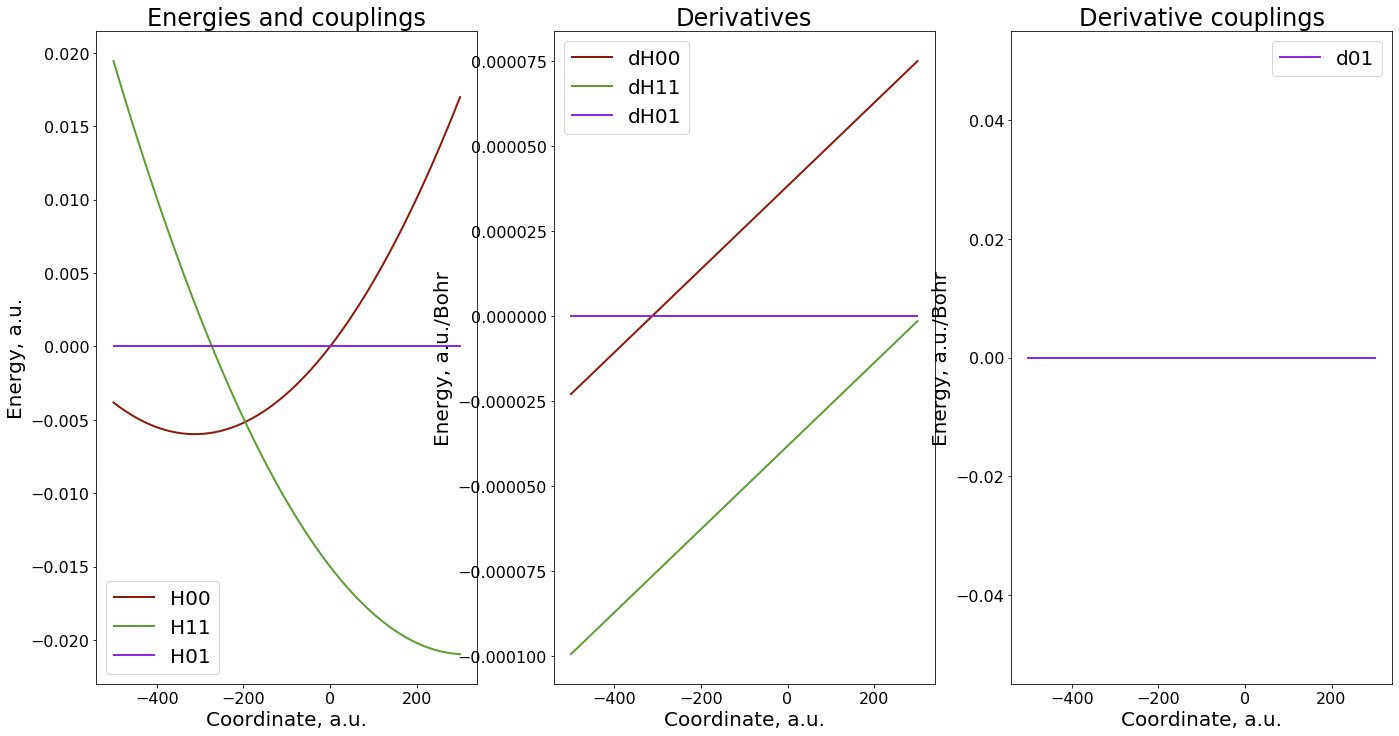

In [6]:
plot_properties(X, compute_model, {"model":1}, {"rep_tdse":0, "rep_ham":0} )

### Option 2.
Now, we want adiabatic properties but the model returns only the diabatic properties, so the needed calculations will be done under the hood

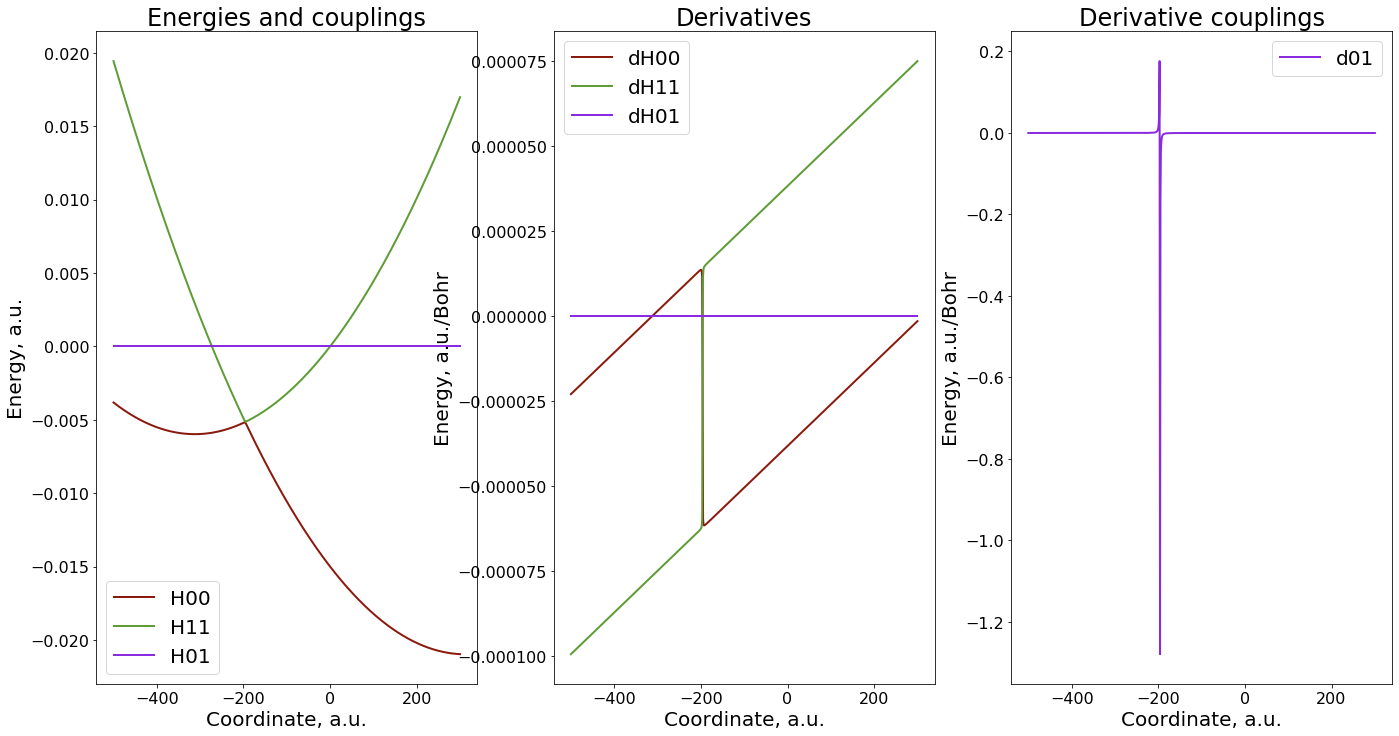

In [7]:
plot_properties(X, compute_model, {"model":1}, {"rep_tdse":1, "rep_ham":0} )

### Option 3.
Finally, we want adiabatic properties - and out Hamiltonian already returns them via analytical expression - so no additional diaginalization is dune.

Note, how we also requested another model to be called in the model_parameters (third argument).

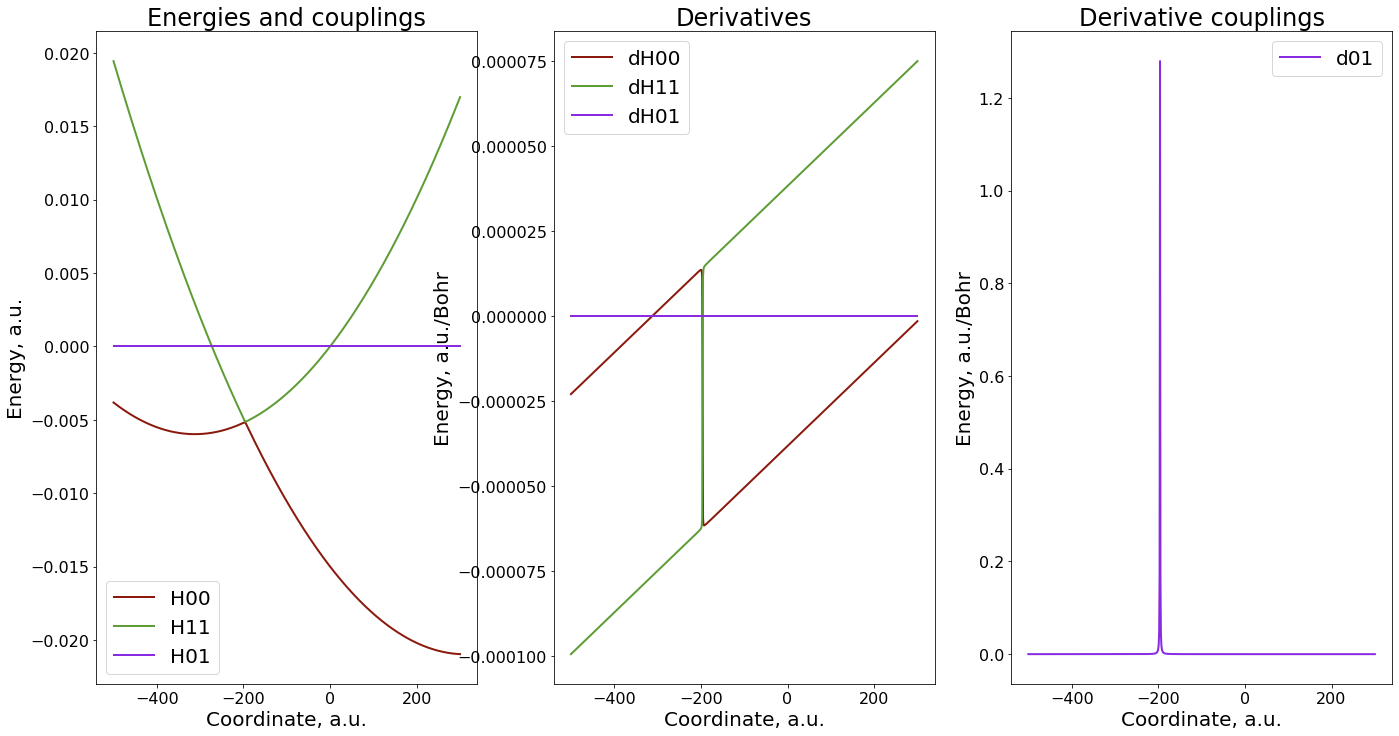

In [8]:
plot_properties(X, compute_model, {"model":2}, {"rep_tdse":1, "rep_ham":1} )

<a name="initial-conditions"></a> [Back to TOC](#TOC)
## 3. Setting up the initial conditions

Before, we run the calculations, we need to initialize our dynmaical variables - both electronic and nuclear. There are many options to do this.


* A. Initial conditions in adiabatic rep
* B. Initial conditions in diabatic rep


In [9]:
# Random numbers generator object
rnd = Random()


rep_init = 1  # in terms of adiabatic amplitudes

ntraj = 25

# Initialize nuclear variables
init_nucl = {"init_type":3, "force_constant":[0.001], "ntraj":ntraj}
q, p, iM = dynamics.init_nuclear_dyn_var([-300.0], [20.0], [2000.0], init_nucl, rnd)

# Initialize electronic variables
init_elec = { "init_type":3, "nstates":2, "istate":0, "istates":[0.0, 1.0], "rep":rep_init,  "ntraj":ntraj  }
Cdia, Cadi, states = dynamics.init_electronic_dyn_var(init_elec, rnd)

print(q, p, iM, Cdia, Cadi, states, len(states))

<liblibra_core.MATRIX object at 0x7f3559170e68> <liblibra_core.MATRIX object at 0x7f3559685ae8> <liblibra_core.MATRIX object at 0x7f3559685810> <liblibra_core.CMATRIX object at 0x7f3559685df8> <liblibra_core.CMATRIX object at 0x7f3559685e68> <liblibra_core.intList object at 0x7f3559685730> 25


In addition, we may want to perform the transformation for the amplitudes.

In [10]:
ndia, nadi, nnucl = Cdia.num_of_rows, Cadi.num_of_rows, q.num_of_rows

ham = nHamiltonian(ndia, nadi, nnucl)
ham.add_new_children(ndia, nadi, nnucl, ntraj)
ham.init_all(2,1)

update_Hamiltonian_q({"rep_tdse":1, "rep_ham":0}, q, ham, compute_model, {"model":1})

if rep_init==0:
    Cadi = transform_amplitudes(0, 1, Cdia, ham)
elif rep_init==1:    
    Cdia = transform_amplitudes(1, 0, Cadi, ham)
            
print(q, p, iM, Cdia, Cadi, states, len(states))

<liblibra_core.MATRIX object at 0x7f3559170e68> <liblibra_core.MATRIX object at 0x7f3559685ae8> <liblibra_core.MATRIX object at 0x7f3559685810> <liblibra_core.CMATRIX object at 0x7f3587553b10> <liblibra_core.CMATRIX object at 0x7f3559685e68> <liblibra_core.intList object at 0x7f3559685730> 25


Since in all examples below, we want to focus only on the methodologies, we will keep the initial conditions identical for all cases.

We also assume we start at the first (left) diabatic surface.

What is convenient in the setup below is that once the initial conditions are generated in one place, the identical copies will be used in each of the consecutive runs. The dynamical variables like q, p, etc. are not modified inside of the functions, Instead, new copies will be created internally and THEY will be modified and printed out (if requested), not the variables we put as the input below. This is convenient, since we can then use the same random samplings in all the runs. 

<a name="dynamics"></a> [Back to TOC](#TOC)

## 4. Dynamics - a single scattering run


There are several scenarios of how NA-MD can be run.


1. **Ehrenfest dynamics** (force_method = 2)

 1.1. TDSE amplitudes in adiabatic rep (rep_tdse = 1)
 
  * [1.1.1.](#case-1-1-1) Ham is given in diabatic rep and converted to adiabatic (rep_ham = 0)
  
  * [1.1.2.](#case-1-1-2) Ham is given in adiabatic rep already (rep_ham = 1)
  
 1.2. TDSE amplitudes in diabatic rep (rep_tdse = 0)
  
  * [1.2.1.](#case-1-2-1) Ham is given in diabatic rep (rep_ham = 0)       
   
      
2. **TSH dynamics** (force_method = 1)

 2.1. TDSE amplitudes in adiabatic rep (rep_tdse = 1)
   
  * 2.1.1. Ham is given in diabatic rep and converted to adiabatic (rep_ham = 0)           
    
    * [2.1.1.1.](#case-2-1-1-1) adiabatic dynamics - no surface hopping (tsh_method = -1)
      
    * 2.1.1.2. surface hopping (tsh_method >= 0)           
      
      * [2.1.1.2.1.](#case-2-1-1-2-1) FSSH surface hopping (tsh_method = 0)
        
      * [2.1.1.2.2.](#case-2-1-1-2-2) GSSH surface hopping (tsh_method = 1)
       
      * [2.1.1.2.3.](#case-2-1-1-2-3) MSSH surface hopping (tsh_method = 2)           
        
   * 2.1.2. Ham is given in adiabatic rep already (rep_ham = 1)
      
      * [2.1.2.1.](#case-2-1-2-1) adiabatic dynamics - no surface hopping (tsh_method = -1)
      
      * 2.1.2.2. surface hopping (tsh_method >= 0)           
      
        * [2.1.2.2.1.](#case-2-1-2-2-1) FSSH surface hopping (tsh_method = 0)
       
        * [2.1.2.2.2.](#case-2-1-2-2-2) GSSH surface hopping (tsh_method = 1)
        
        * [2.1.2.2.3.](#case-2-1-2-2-3) MSSH surface hopping (tsh_method = 2)               
        
 2.2. TDSE amplitudes in diabatic rep (rep_tdse = 0)
 
  * 2.2.1. Ham is given in diabatic rep (rep_ham = 0)
           

3. **NBRA-TSH, No forces** (force_method = 0)




----

In addition, a number of settings can be kept fixed - they are outside of our current focus, so can be defined here only once

In [11]:
dyn_params = { "rep_sh":1, "rep_lz":0, "nac_update_method":1,
               "use_boltz_factor":0,  "do_reverse":1, "vel_rescale_opt":0,
               "state_tracking_algo":2, "MK_alpha":0.0, "MK_verbosity":0,
               "do_phase_correction":1, "tol":1e-3,               
               "nsteps":2000, "dt":10.0,
               "output_level":2,  "file_output_level":0               
              }

Also, lets define a function for plotting properties of interest

In [12]:
def plot_dyn(res):
    # Format: 
    #   0      1      2       3        4        5           6          7        8            9       10        11            12        13       14         15             16          17
    #obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states obs_hvib_adi obs_hvib_dia  obs_St

    obs_T = res[0]
    obs_Ekin = res[3]
    obs_Epot = res[4]
    obs_Etot = res[5]
    obs_dEkin = res[6]
    obs_dEpot = res[7]
    obs_dEtot = res[8]
    obs_dm_adi00 = data_conv.unpack1(res[11], 0, 0, 0)
    obs_dm_adi11 = data_conv.unpack1(res[11], 1, 1, 0)
    obs_dm_dia00 = data_conv.unpack1(res[12], 0, 0, 0)
    obs_dm_dia11 = data_conv.unpack1(res[12], 1, 1, 0)
    obs_pop00 = data_conv.unpack1(res[13], 0, 0, 2)
    obs_pop11 = data_conv.unpack1(res[13], 1, 0, 2)
    obs_q = data_conv.unpack1(res[1], 0, 0, 2)
    obs_p = data_conv.unpack1(res[2], 0, 0, 2)
    
    ndof = res[1][0].num_of_rows
    ntraj = res[1][0].num_of_cols
    

    plt.figure(1, figsize=(24, 24)) # dpi=300, frameon=False)

    plt.subplot(3,2,1)
    plt.title('q-t')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Coordiante, a.u.')
    
    for tr in range(ntraj):
        obs_q = data_conv.unpack1(res[1], 0, tr, 2)
        plt.plot(obs_T, obs_q, label="", linewidth=2, color = colors["11"])   # label='q vs. t'
    plt.legend()

    plt.subplot(3,2,2)
    plt.title('Phase portrait')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Momentum, a.u.')    
    for tr in range(ntraj):
        obs_q = data_conv.unpack1(res[1], 0, tr, 2)
        obs_p = data_conv.unpack1(res[2], 0, tr, 2)
        plt.plot(obs_q, obs_p, linewidth=2, color = colors["11"])  # label='p vs. q'
    plt.legend()

    plt.subplot(3,2,3)
    plt.title('Adiabatic populations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population of state 0')
    plt.plot(obs_T, obs_pop00, "--o", label='SH P(0)', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dm_adi00, "--o", label='SE P(0)', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_pop11, "--", label='SH P(1)', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dm_adi11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(3,2,4)
    plt.title('Diabatic populations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population of state 0')
    plt.plot(obs_T, obs_dm_dia00, label='SE P(0)', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_dm_dia11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(3,2,5)
    plt.title('Energies')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(obs_T, obs_Ekin, label='Ekin', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_Epot, label='Epot', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_Etot, label='Etot', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(3,2,6)
    plt.title('Energy fluctuations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(obs_T, obs_dEkin, label='dEkin', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dEpot, label='dEpot', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_dEtot, label='dEtot', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()

Now lets consider all the options


## =================  Ehrenfest options ========================

<a name="case-1-1-1"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 1.1.1.    Ehrenfest, adiabatic tdse, diabatic Ham

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 2, 'rep_tdse': 1, 'rep_ham': 0, 'prefix': 'case-1-1-1', 'tsh_method': -1}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


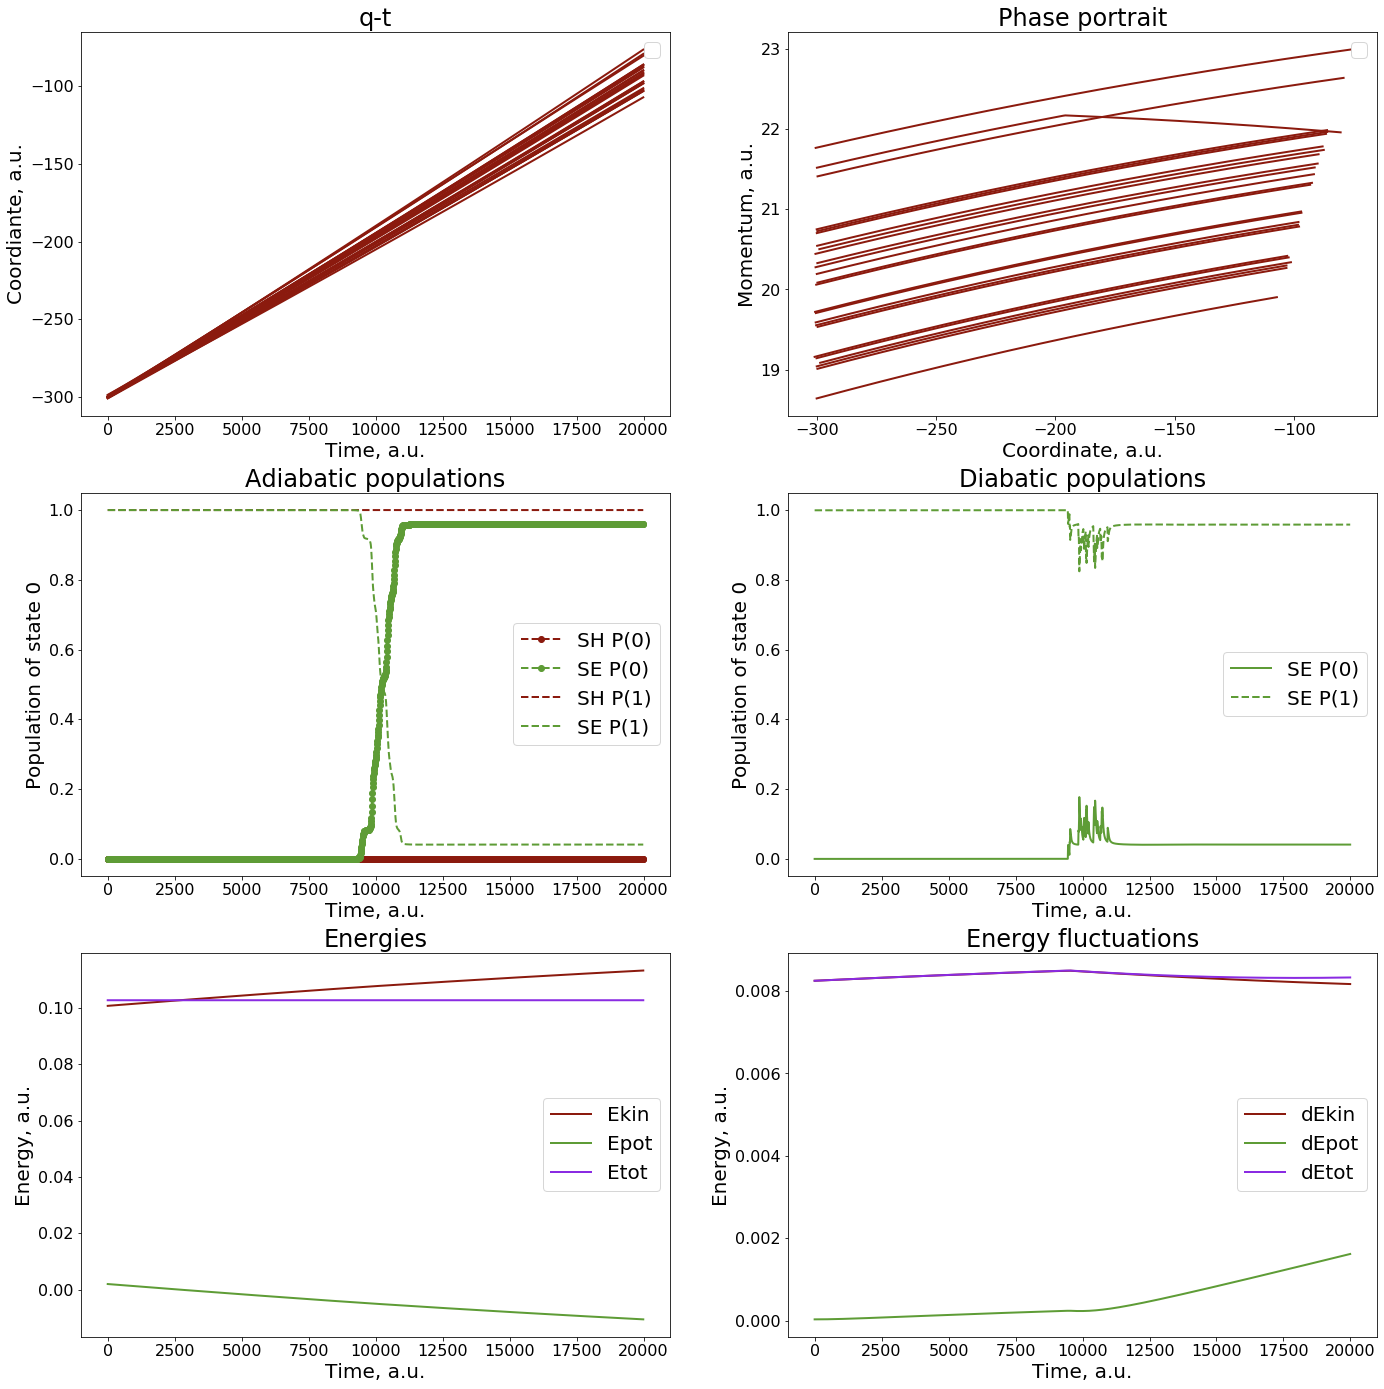

In [13]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":2, "rep_tdse":1, "rep_ham":0, "prefix":"case-1-1-1", "tsh_method":-1, "rep_sh":1 })

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":1}, dyn_params, compute_model, rnd)
plot_dyn(res)

<a name="case-1-1-2"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 1.1.2.  Ehrenfest, adiabatic tdse, adiabatic Ham

Unless we provide MOs (adiabatic - diabatic transformation matrix), we can't use state tracking. So, in this case we temporarily turn the state tracking off

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 0, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 2, 'rep_tdse': 1, 'rep_ham': 1, 'prefix': 'case-1-1-2', 'tsh_method': -1, 'tsh_version': 2}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


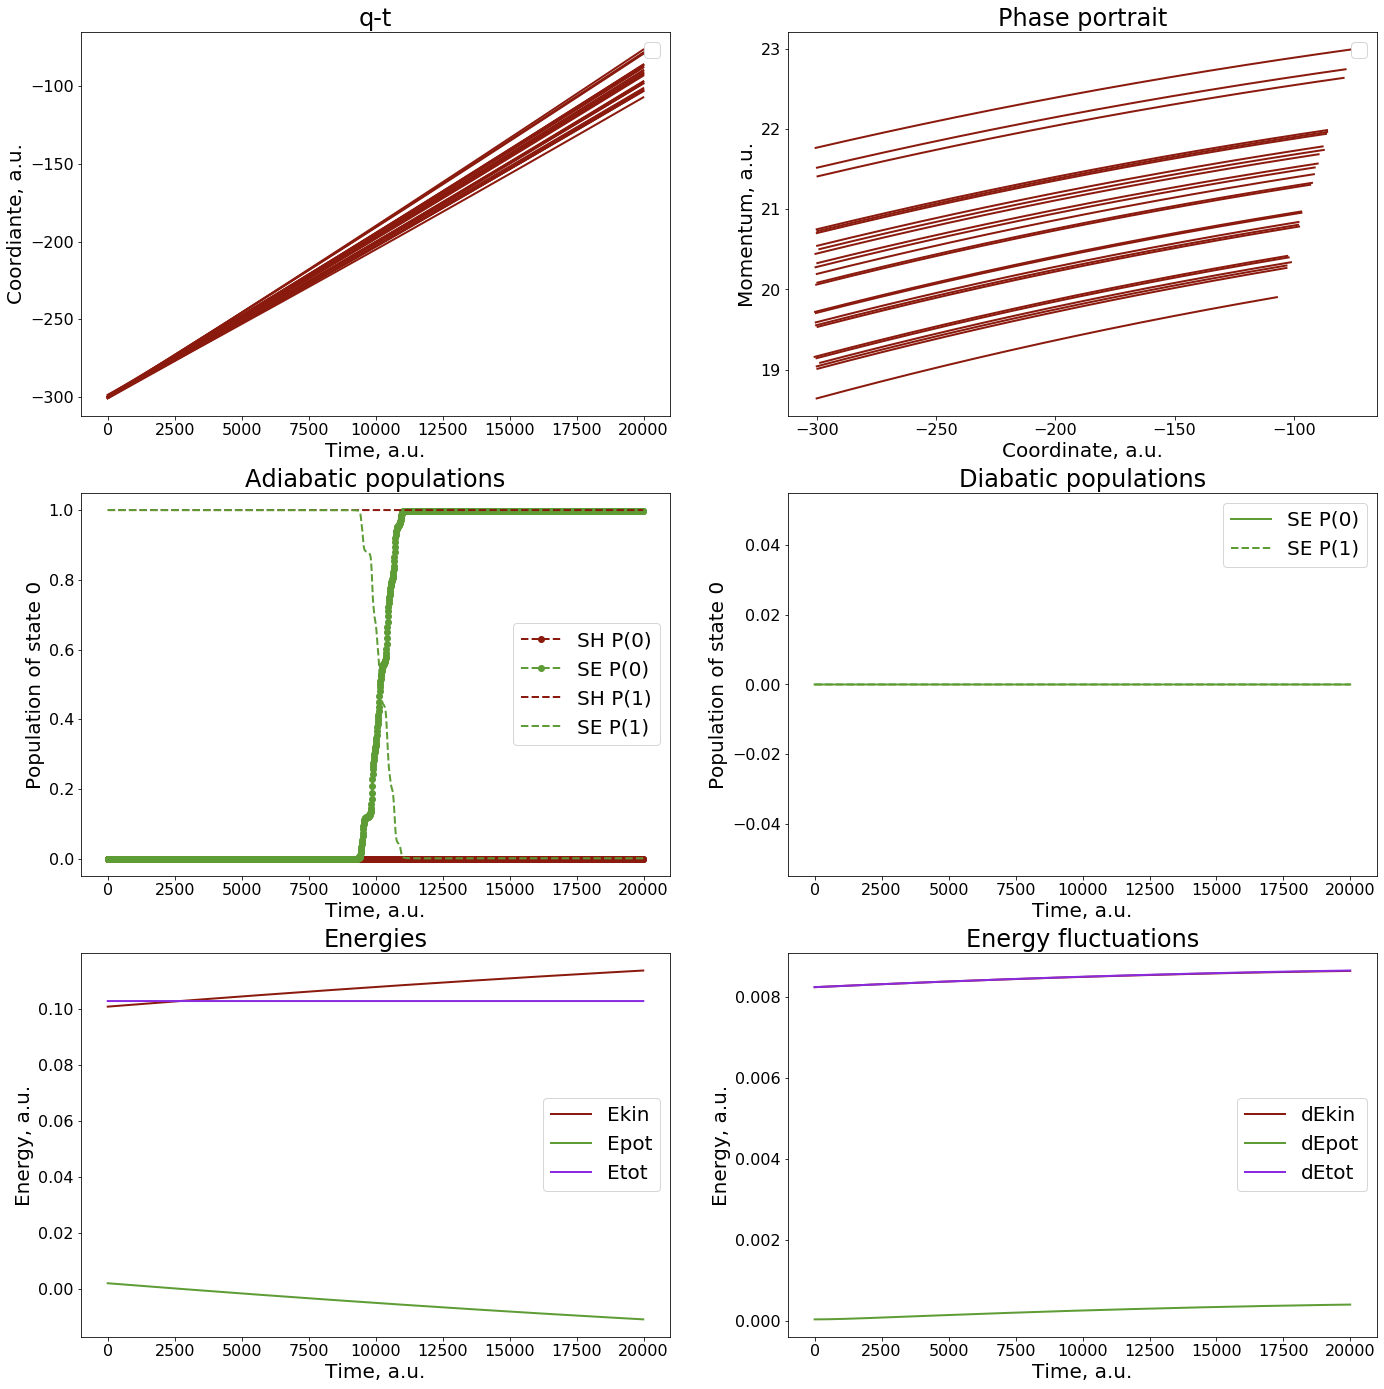

In [14]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":2, "rep_tdse":1, "rep_ham":1, "prefix":"case-1-1-2", "tsh_method":-1, "rep_sh":1 })
dyn_params.update({"state_tracking_algo":0})

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":2}, dyn_params, compute_model, rnd)
plot_dyn(res)

dyn_params.update({"state_tracking_algo":2})

<a name="case-1-2-1"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 1.2.1.    Ehrenfest, diabatic tdse, diabatic Ham

In this case, we do not need phase corrections or state tracking

{'rep_sh': 0, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 0, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 0, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 2, 'rep_tdse': 0, 'rep_ham': 0, 'prefix': 'case-1-2-1', 'tsh_method': -1, 'tsh_version': 2}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


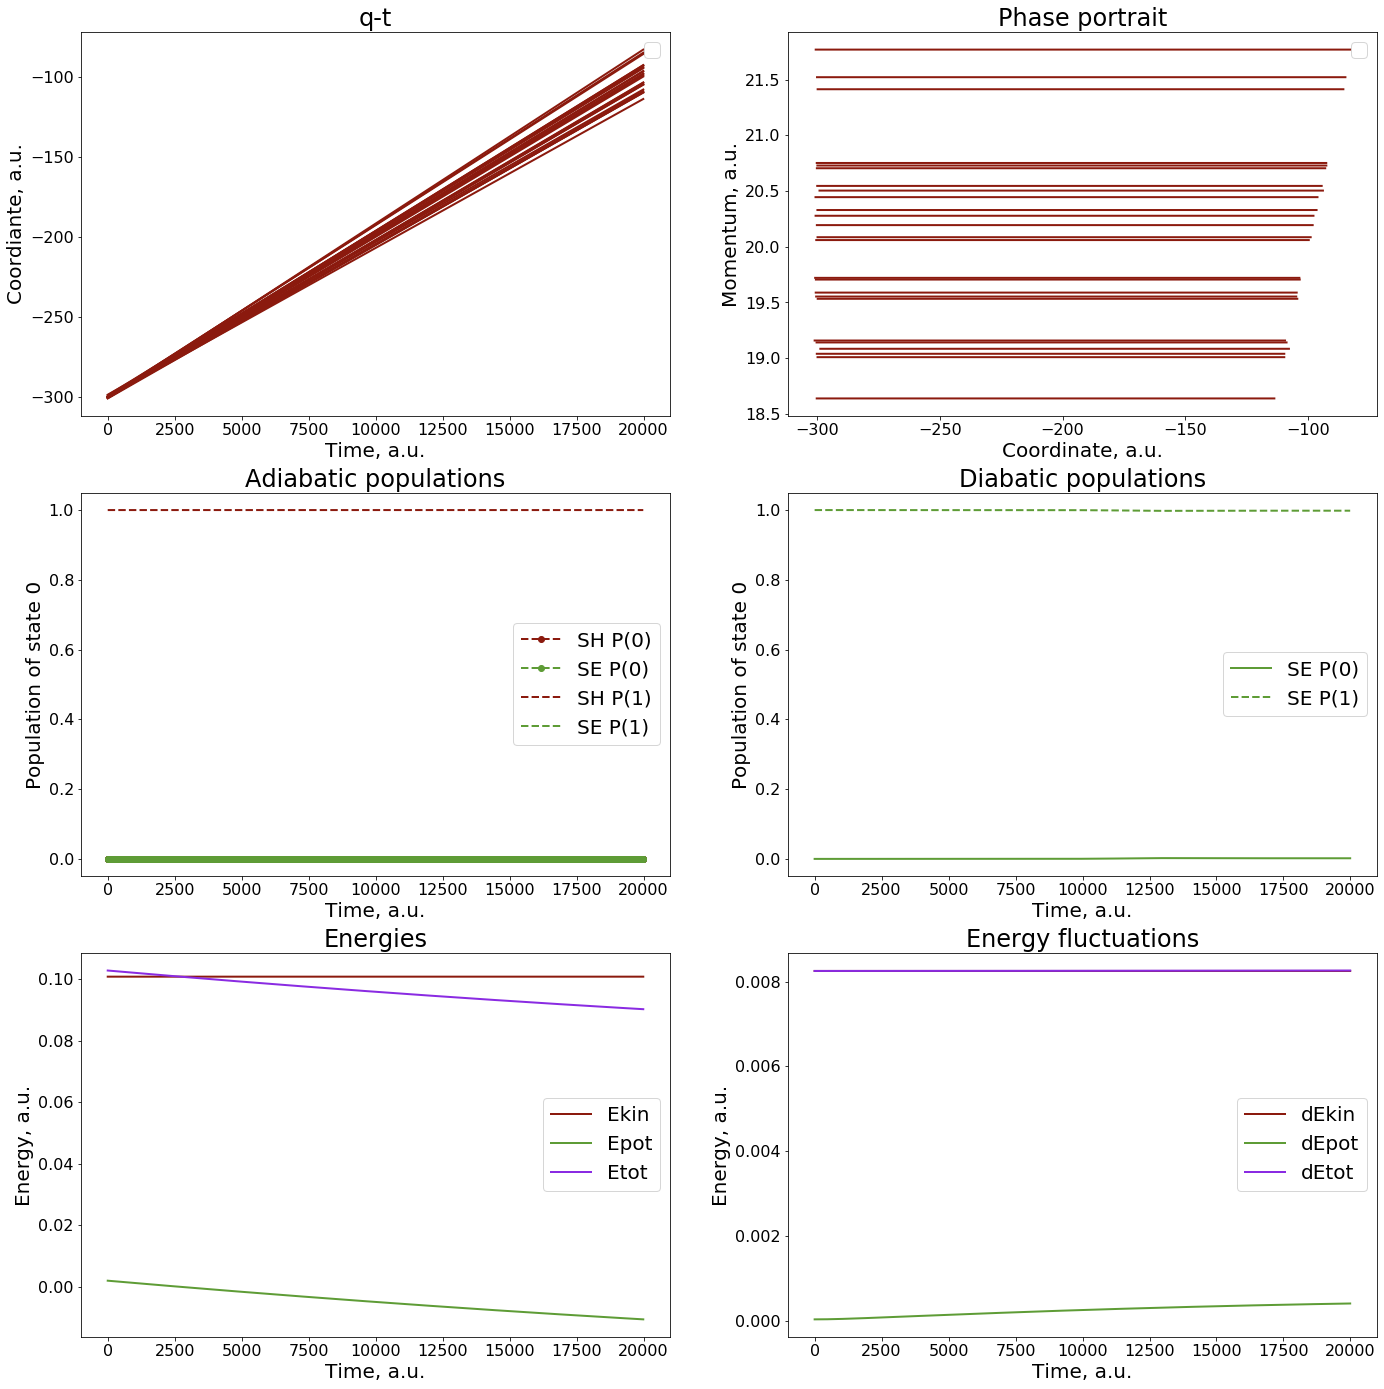

In [15]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":2, "rep_tdse":0, "rep_ham":0, "prefix":"case-1-2-1", "tsh_method":-1, "rep_sh":0 })
dyn_params.update({"state_tracking_algo":0, "do_phase_correction":0}) 

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":1}, dyn_params, compute_model, rnd)
plot_dyn(res)

dyn_params.update({"state_tracking_algo":2, "do_phase_correction":1})

## =================  TSH options ========================

<a name="case-2-1-1-1"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)
### Case 2.1.1.1. Adiabatic dynamics (no hops), TDSE is in adiabatic rep, Ham in diabatic

In this case, the SH populations won't change, but the TD-SE popultations may change - but regard this simply as the TD-SE evolution along a classical (adiabatic) trajectories. The evolved amplitudes do not affect the nuclear dynamics. 

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 1, 'rep_tdse': 1, 'rep_ham': 0, 'prefix': 'case-2-1-1-1', 'tsh_method': -1, 'tsh_version': 2}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


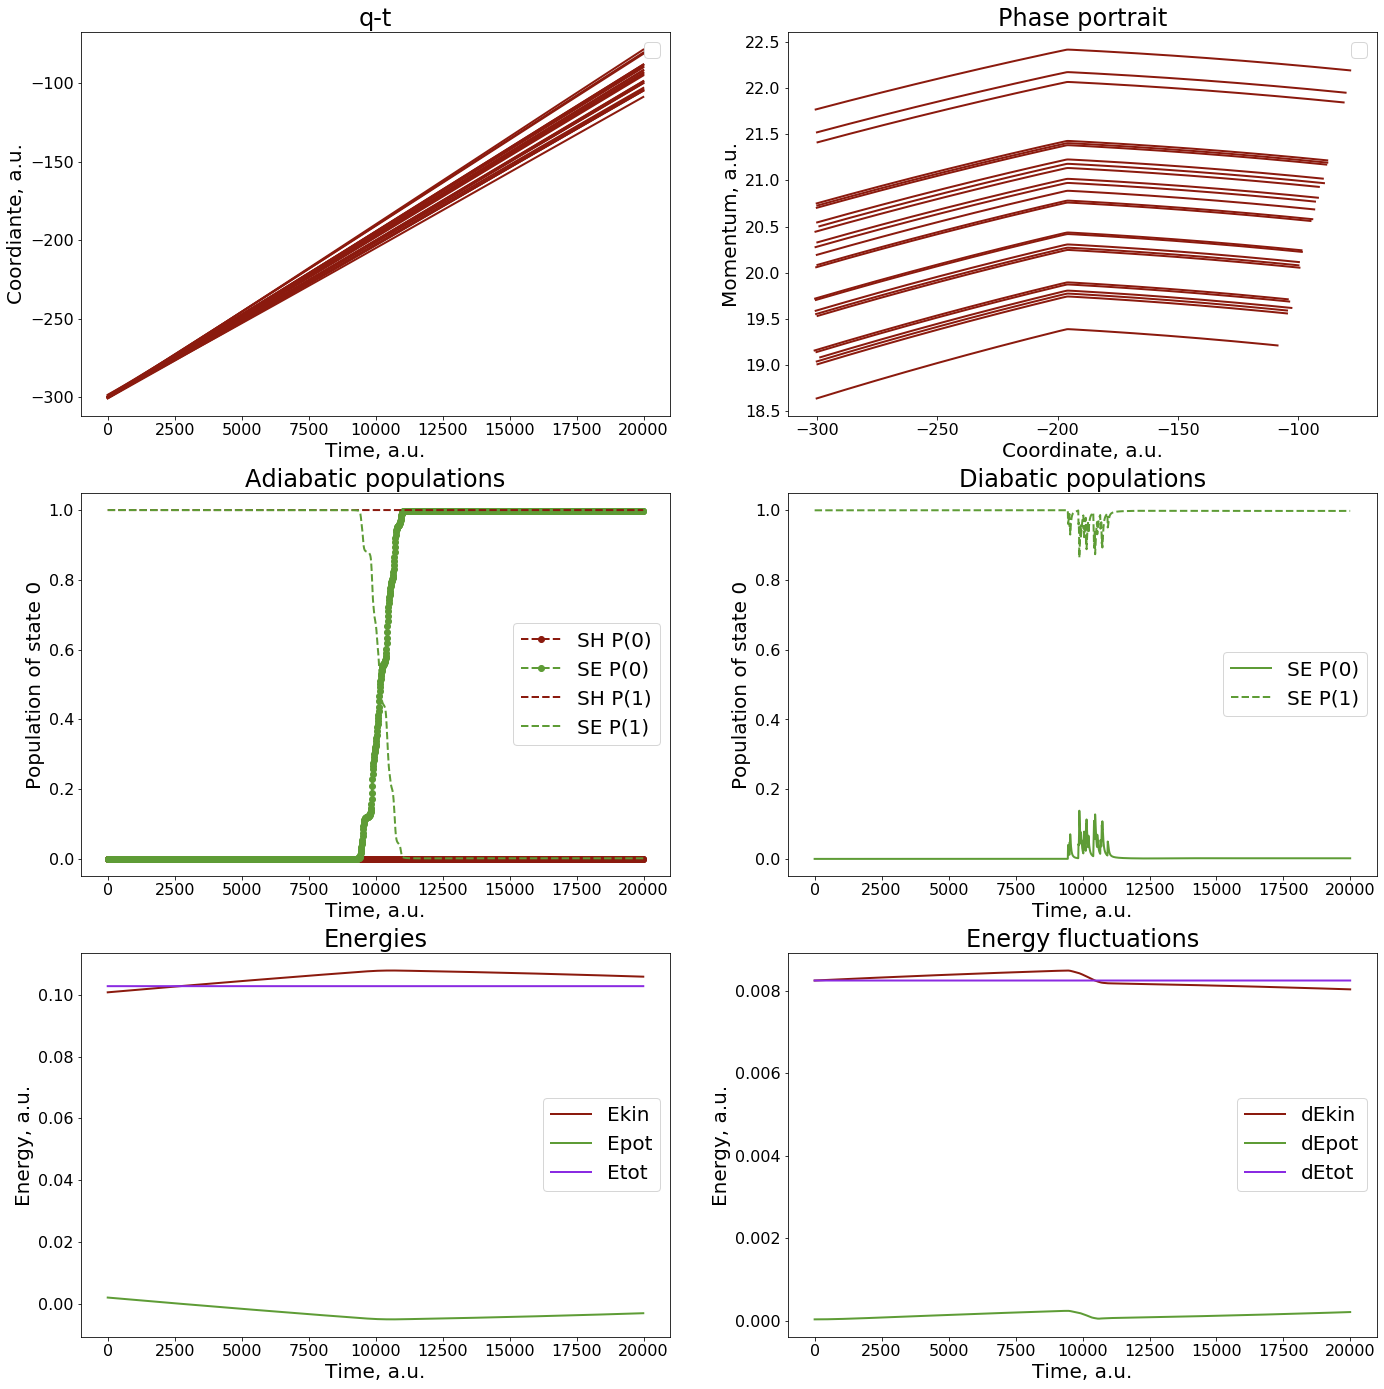

In [16]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":1, "rep_tdse":1, "rep_ham":0, "prefix":"case-2-1-1-1", "tsh_method":-1, "rep_sh":1 })

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":1}, dyn_params, compute_model, rnd)
plot_dyn(res)

<a name="case-2-1-1-2-1"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)
### Case 2.1.1.2.1.  FSSH, TDSE is in adiabatic rep, Ham in diabatic

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 1, 'rep_tdse': 1, 'rep_ham': 0, 'prefix': 'case-2-1-1-2-1', 'tsh_method': 0, 'tsh_version': 2}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


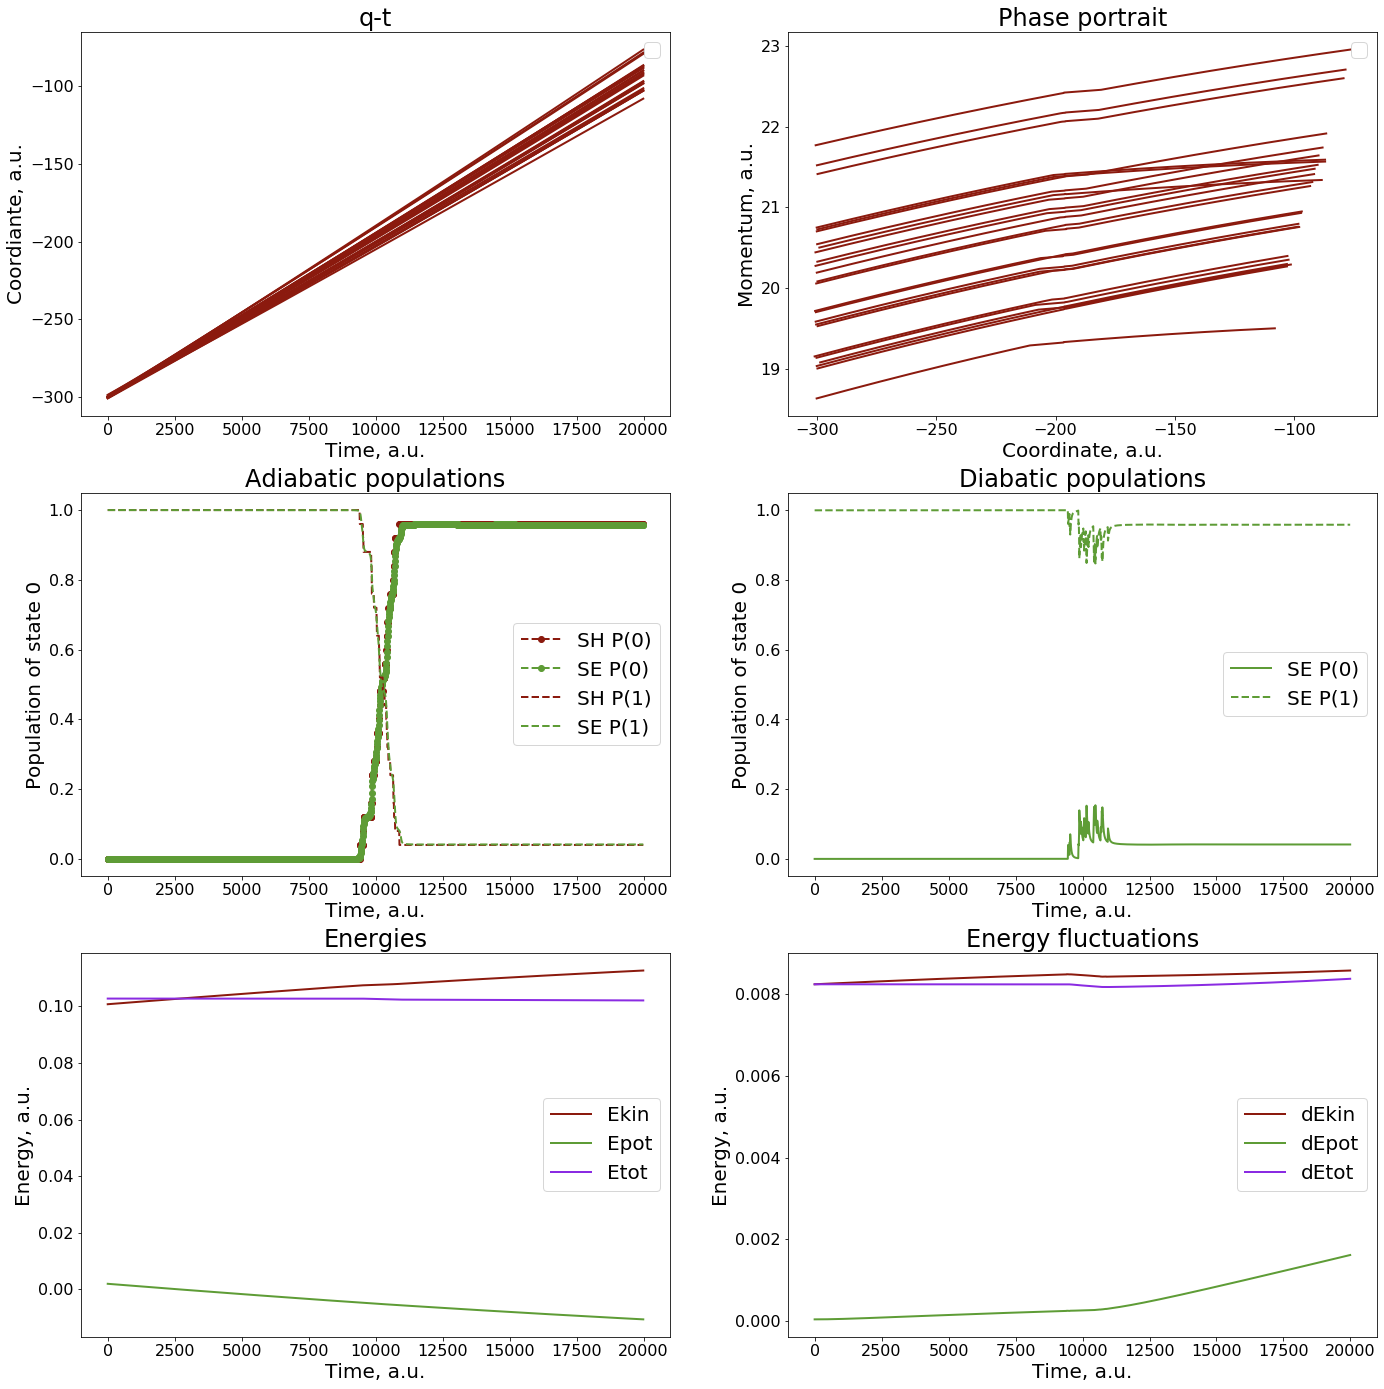

In [17]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":1, "rep_tdse":1, "rep_ham":0, "prefix":"case-2-1-1-2-1", "tsh_method":0, "rep_sh":1 })

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":1}, dyn_params, compute_model, rnd)
plot_dyn(res)

<a name="case-2-1-1-2-2"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)
### Case 2.1.1.2.2. GFSH, TDSE is in adiabatic rep, Ham in diabatic

In [18]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":1, "rep_tdse":1, "rep_ham":0, "prefix":"case-2-1-1-2-2", "tsh_method":1, "rep_sh":1 })

print(dyn_params)
#res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":1}, dyn_params, compute_model, rnd)
#plot_dyn(res)

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 1, 'rep_tdse': 1, 'rep_ham': 0, 'prefix': 'case-2-1-1-2-2', 'tsh_method': 1, 'tsh_version': 2}


<a name="case-2-1-1-2-3"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)
### Case 2.1.1.2.3. MSSH, TDSE is in adiabatic rep, Ham in diabatic

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 1, 'rep_tdse': 1, 'rep_ham': 0, 'prefix': 'case-2-1-1-2-3', 'tsh_method': 2, 'tsh_version': 2}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


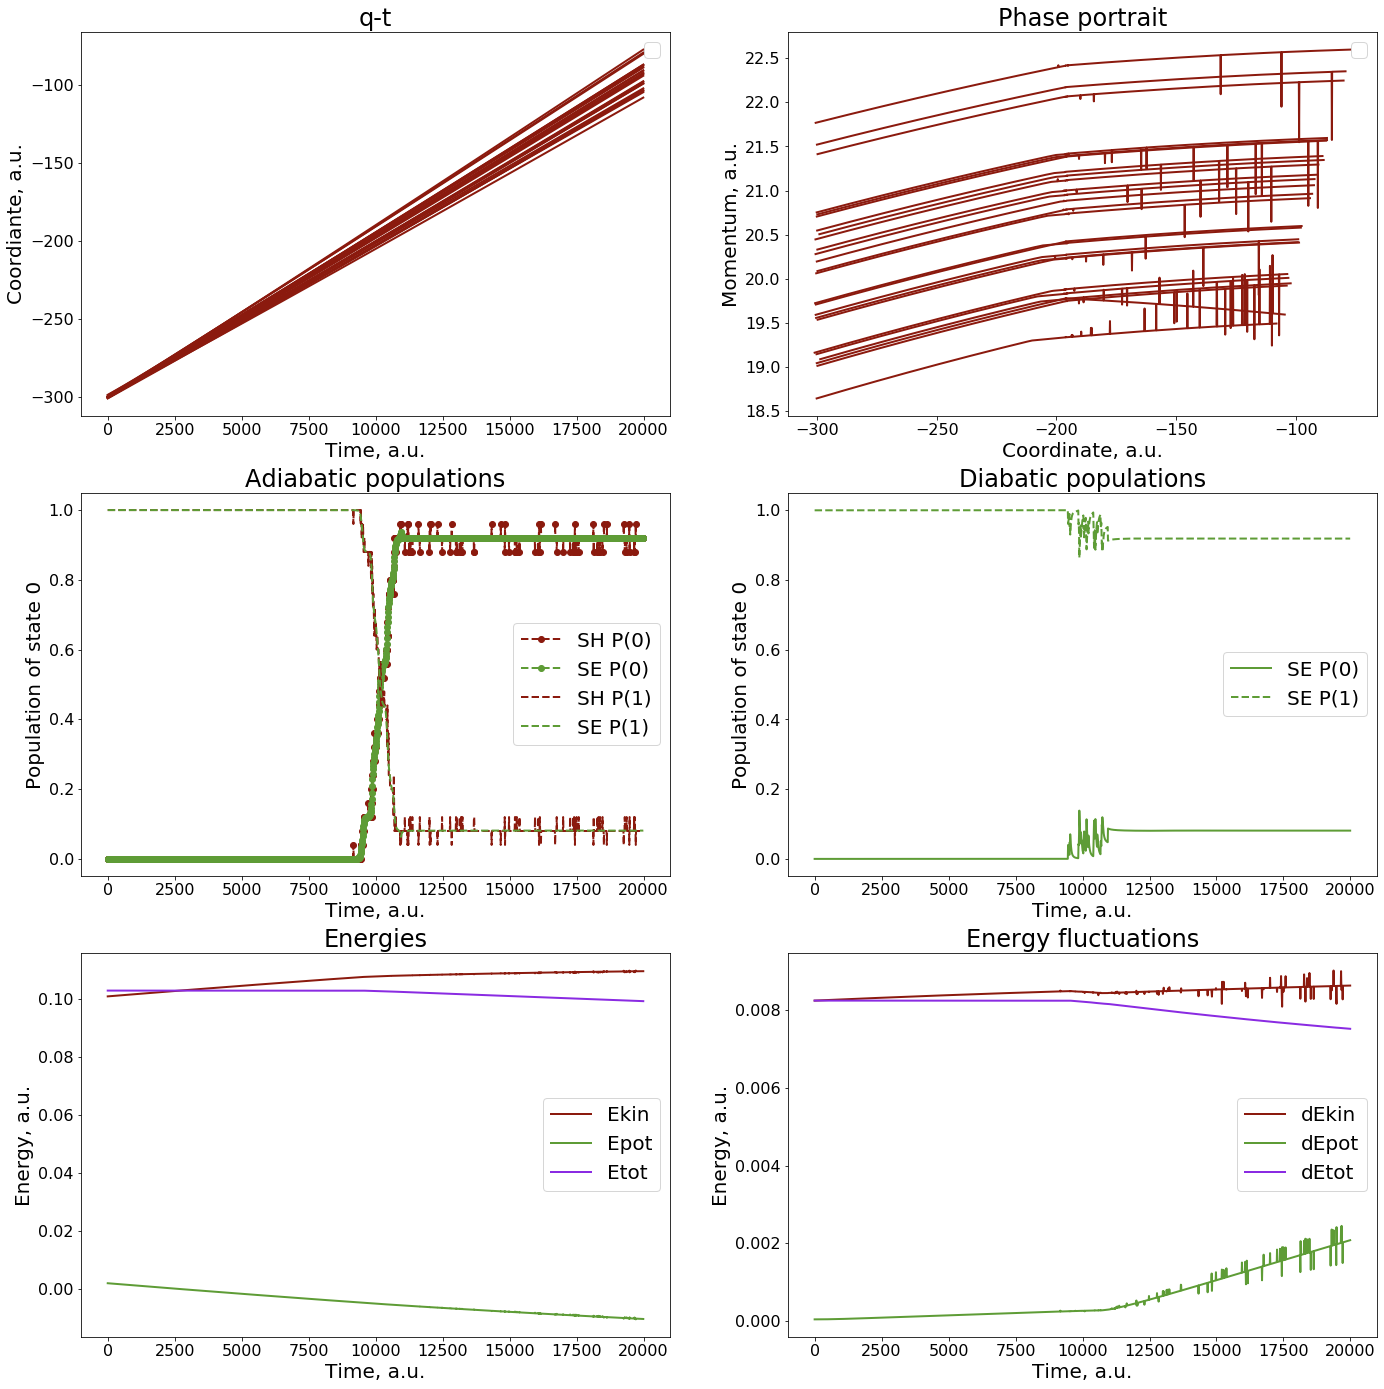

In [19]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":1, "rep_tdse":1, "rep_ham":0, "prefix":"case-2-1-1-2-3", "tsh_method":2, "rep_sh":1 })

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":1}, dyn_params, compute_model, rnd)
plot_dyn(res)

<a name="case-2-1-2-1"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)
### Case 2.1.2.1. Adiabatic dynamics (no hops), TDSE is in adiabatic rep, Ham in adiabatic

In this case, the SH populations won't change, but the TD-SE popultations may change - but regard this simply as the TD-SE evolution along a classical (adiabatic) trajectories. The evolved amplitudes do not affect the nuclear dynamics. 

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 1, 'rep_tdse': 1, 'rep_ham': 1, 'prefix': 'case-2-1-2-1', 'tsh_method': -1, 'tsh_version': 2}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


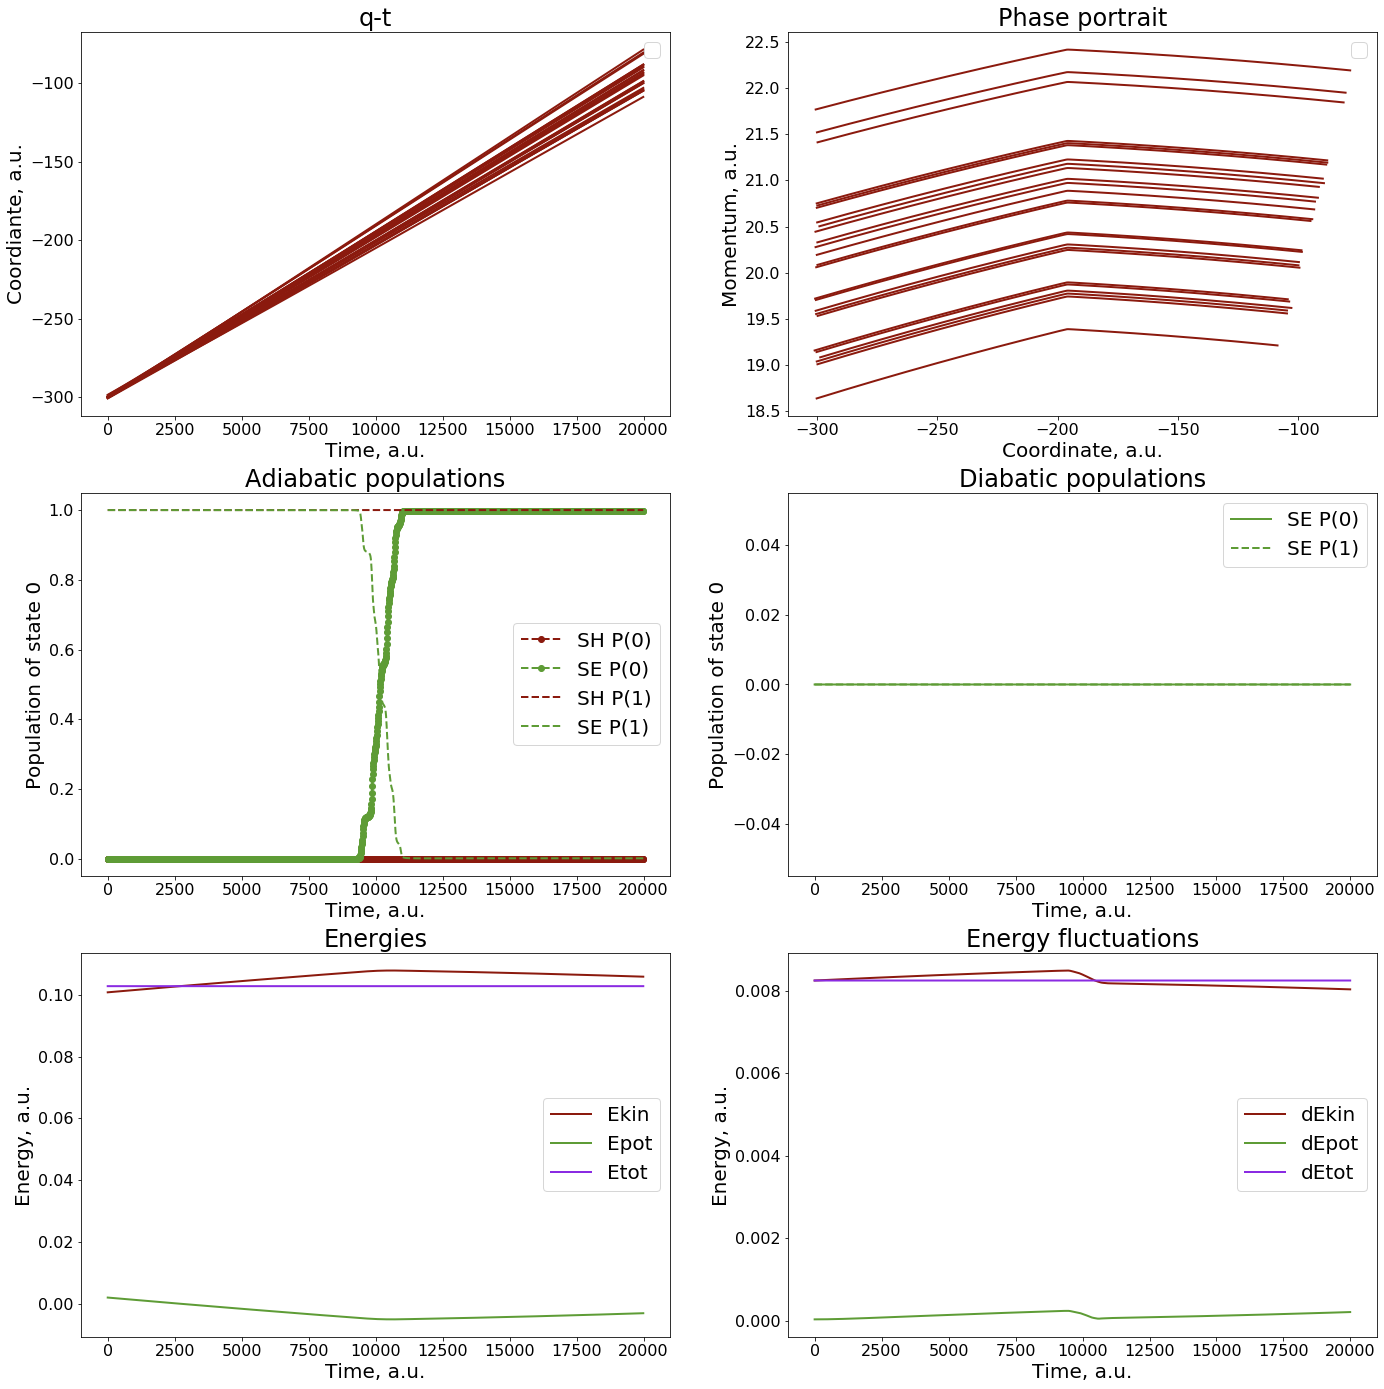

In [20]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":1, "rep_tdse":1, "rep_ham":1, "prefix":"case-2-1-2-1", "tsh_method":-1, "rep_sh":1 })

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":2}, dyn_params, compute_model, rnd)
plot_dyn(res)

<a name="case-2-1-2-2-1"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)
### Case 2.1.2.2.1. FSSH, TDSE is in adiabatic rep, Ham in adiabatic

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 1, 'rep_tdse': 1, 'rep_ham': 1, 'prefix': 'case-2-1-2-2-1', 'tsh_method': 0, 'tsh_version': 2}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


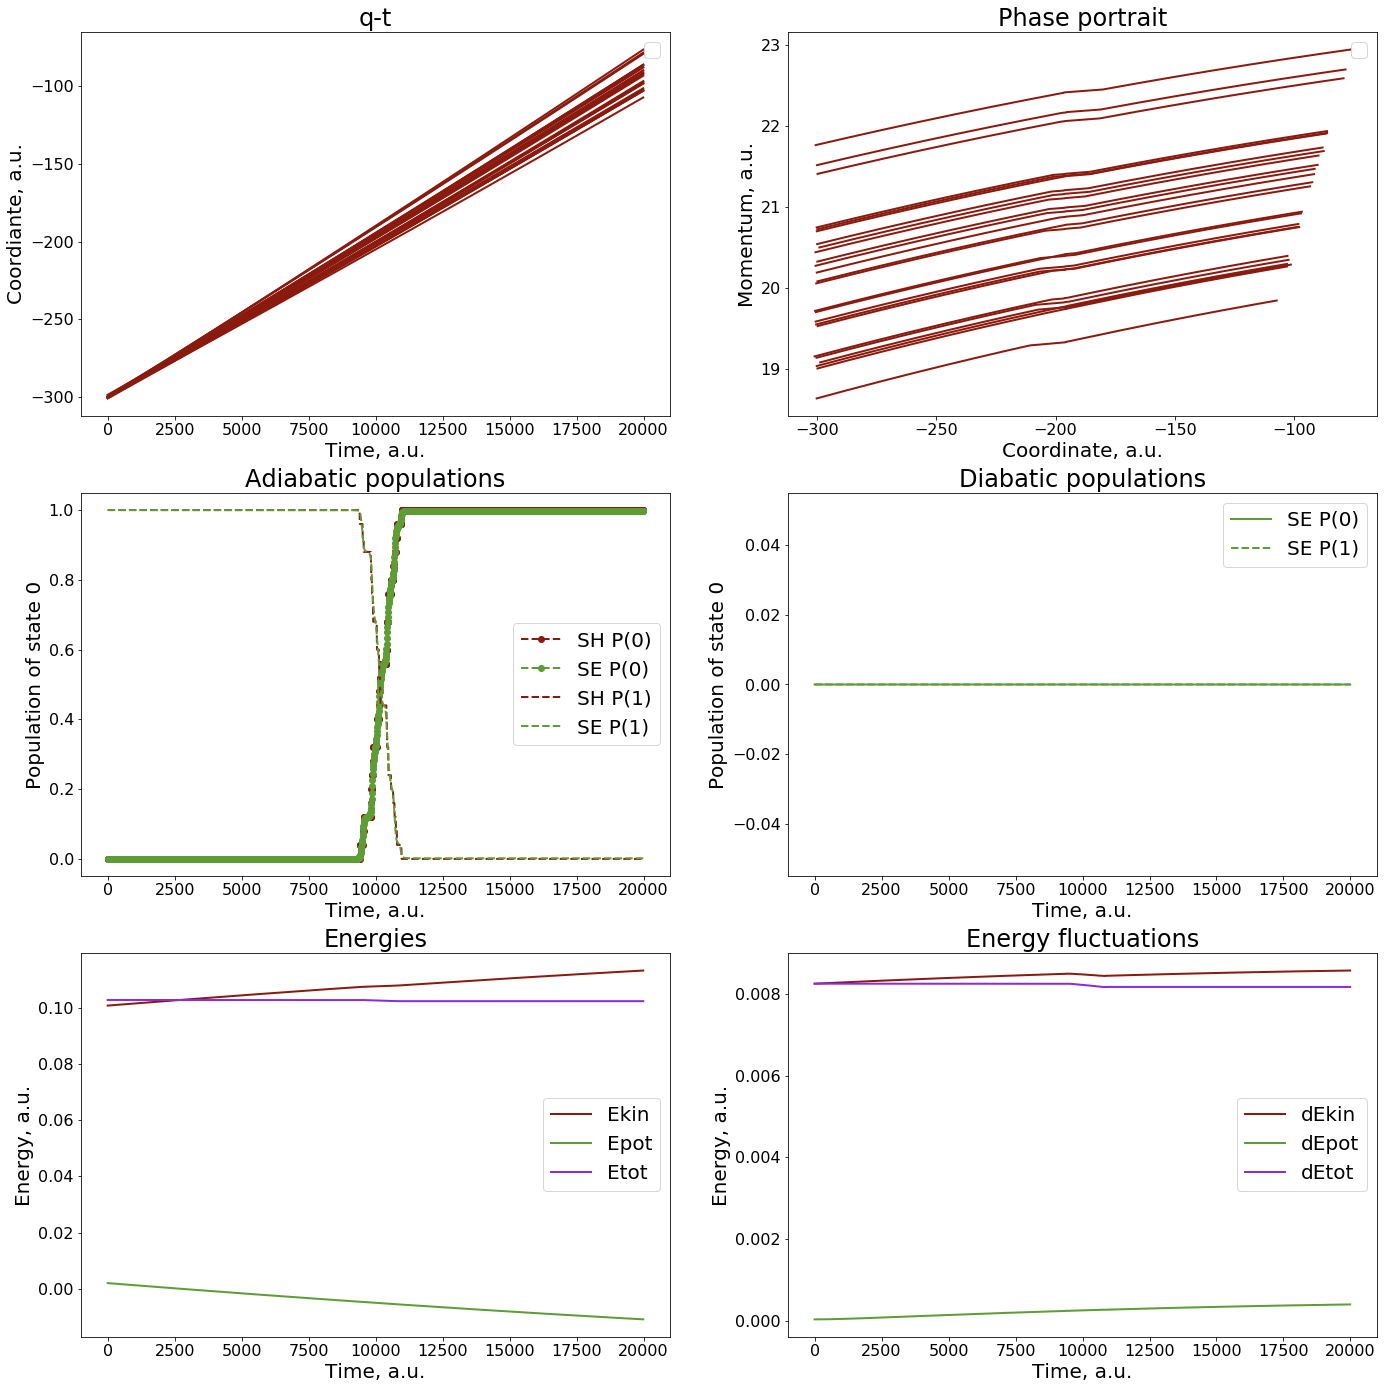

In [21]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":1, "rep_tdse":1, "rep_ham":1, "prefix":"case-2-1-2-2-1", "tsh_method":0, "rep_sh":1 })

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":2}, dyn_params, compute_model, rnd)
plot_dyn(res)

<a name="case-2-1-2-2-2"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)
### Case 2.1.2.2.2. GFSH, TDSE is in adiabatic rep, Ham in adiabatic

In [22]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":1, "rep_tdse":1, "rep_ham":1, "prefix":"case-2-1-2-2-2", "tsh_method":1, "rep_sh":1 })

print(dyn_params)
#res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":2}, dyn_params, compute_model, rnd)
#plot_dyn(res)

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 1, 'rep_tdse': 1, 'rep_ham': 1, 'prefix': 'case-2-1-2-2-2', 'tsh_method': 1, 'tsh_version': 2}


<a name="case-2-1-2-2-3"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)
### Case 2.1.2.2.3. MSSH, TDSE is in adiabatic rep, Ham in adiabatic

{'rep_sh': 1, 'rep_lz': 0, 'nac_update_method': 1, 'use_boltz_factor': 0, 'do_reverse': 1, 'vel_rescale_opt': 0, 'state_tracking_algo': 2, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'do_phase_correction': 1, 'tol': 0.001, 'nsteps': 2000, 'dt': 10.0, 'output_level': 2, 'file_output_level': 0, 'force_method': 1, 'rep_tdse': 1, 'rep_ham': 1, 'prefix': 'case-2-1-2-2-3', 'tsh_method': 2, 'tsh_version': 2}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


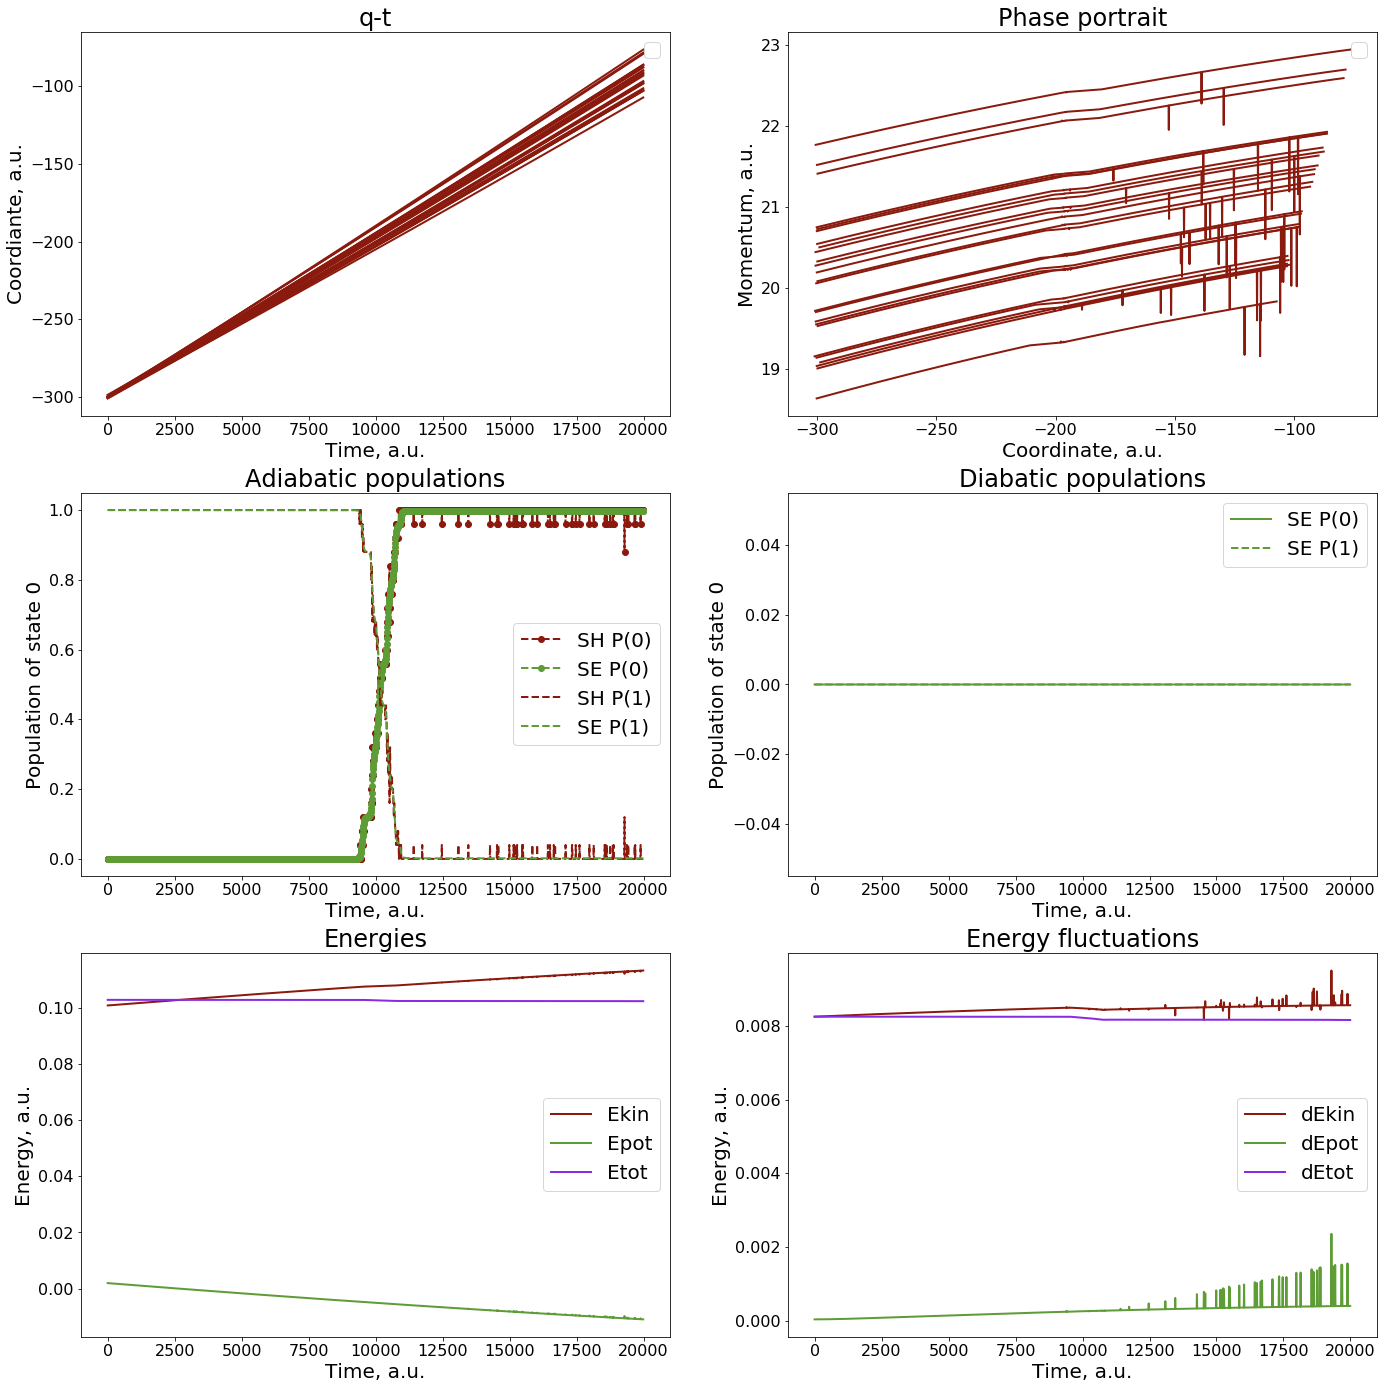

In [23]:
# Dynamics (Simulation) parameters
dyn_params.update({ "force_method":1, "rep_tdse":1, "rep_ham":1, "prefix":"case-2-1-2-2-3", "tsh_method":2, "rep_sh":1 })

print(dyn_params)
res = dynamics.run_dynamics(q, p, iM, Cdia, Cadi, states, {"model":2}, dyn_params, compute_model, rnd)
plot_dyn(res)